# STS Similarity - Visualizations

In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.models import load_model, model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

import custom_attn

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

# word to id lookup
VOCAB_FILE = os.path.join(DATA_DIR, "sts-vocab.tsv")
# id to vector lookup
GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

MIN_OCCURS = 2
MAX_WORDS = 35

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 200

BEST_MODEL = os.path.join(DATA_DIR, "models", "07b-best-model.h5")
BEST_MODEL_JSON = os.path.join(DATA_DIR, "models", "07b-best-model.json")

In [3]:
# sent_l = "A man is riding a bicycle."
# sent_r = "A man is riding a bike."
# label_sim = 5.0
# # pred_sim = 0.142, -0.807

# sent_l = "A woman is playing the flute."
# sent_r = "A man is playing a flute."
# label_sim = 2.4
# # pred_sim = 0.032, -0.012

sent_l = "A man is cutting a potato."
sent_r = "A woman is cutting a tomato."
label_sim = 1.25
# pred_sim = 0.15, -0.391

## Visualize Inputs

### Load Word Embeddings

In [4]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) < MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 6942


In [5]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(6942, 300)


### Define some functions

In [6]:
def convert_to_sequence(sent, word2id, padding_length=0):
    int_seq = []
    sent = sent.decode("utf8").encode("ascii", "ignore").lower()
    for word in nltk.word_tokenize(sent):
        if word2id.has_key(word):
            int_seq.append(word2id[word])
        else:
            int_seq.append(word2id["UNK"])
    if padding_length > 0:
        return pad_sequences([int_seq], maxlen=padding_length)[0]
    else:
        return int_seq

def convert_to_onehot(sent, word2id, padding_length, vocab_size):
    int_seq = convert_to_sequence(sent, word2id, padding_length)
    return np_utils.to_categorical(int_seq, num_classes=vocab_size)

def plot_alignment_matrix(align, sent_l, sent_r, title, 
                          truncate=True, legend=True, show=True):
    words_l = nltk.word_tokenize(sent_l)
    len_l = len(words_l)
    words_r = nltk.word_tokenize(sent_r)
    len_r = len(words_r)
    if truncate:
        max_len = len_l if len_l > len_r else len_r
        align = align[-max_len:, -max_len:]
    plt.imshow(align, cmap='Blues_r', interpolation='nearest')
    sim = np.sum(np.diag(align)) / np.sum(align)
    plt.title("{:s} (similarity: {:.3f})".format(title, sim))
    plt.yticks(np.arange(len(words_r)), words_r)
    plt.xticks(np.arange(len(words_l)), words_l, rotation="45")
    if legend: 
        plt.colorbar()
    if show:
        plt.show()
    
def print_model_layers(model):
    for layer in model.layers:
        print(layer.name, layer.input_shape, layer.output_shape)

### Visualize Input Alignments (one-hot)

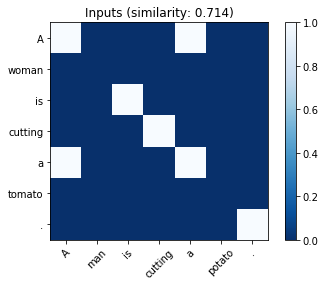

In [7]:
input_l = convert_to_onehot(sent_l, word2id, MAX_WORDS, vocab_size)
input_r = convert_to_onehot(sent_r, word2id, MAX_WORDS, vocab_size)

S_input = np.dot(input_l, input_r.T)
plot_alignment_matrix(S_input, sent_l, sent_r, "Inputs")

Some noteworthy points about the alignment based on the original sentence pair.

* There is lot of word overlap, and this can be seen from the high values along the diagonal.
* "a" occurs twice, so they appear off diagonal as well.
* There is no correspondence between the word pairs (man, woman) and (potato, tomato) that are different.


## Visualize Embeddings

### Original (GloVe) Embeddings

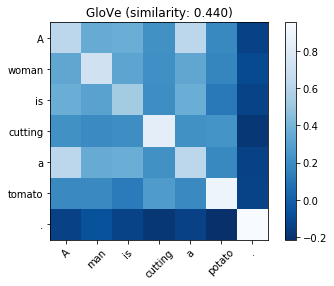

In [8]:
glove_l = np.dot(input_l, E)
glove_r = np.dot(input_r, E)

S_glove = np.dot(glove_l, glove_r.T)
S_glove /= np.max(S_glove)

plot_alignment_matrix(S_glove, sent_l, sent_r, "GloVe")

### Load Model

In [9]:
with open(BEST_MODEL_JSON, "rb") as fin:
    model = model_from_json(fin.read(),
        custom_objects={"AttentionMM": custom_attn.AttentionMM})
model.load_weights(BEST_MODEL)
print_model_layers(model)

input_2 (None, 35) (None, 35)
input_3 (None, 35) (None, 35)
model_1 (None, 35) (None, 35, 200)
attention_mm_1 [(None, 35, 200), (None, 35, 200)] (None, 400)
batch_normalization_1 (None, 400) (None, 400)
dropout_1 (None, 400) (None, 400)
dense_1 (None, 400) (None, 50)
dropout_2 (None, 50) (None, 50)
dense_2 (None, 50) (None, 6)


In [10]:
sent_encoder = model.layers[2]
print_model_layers(sent_encoder)

input_1 (None, 35) (None, 35)
embedding_1 (None, 35) (None, 35, 300)
masking_1 (None, 35, 300) (None, 35, 300)
bidirectional_1 (None, 35, 300) (None, 35, 200)


### Extract fine-tuned Embedding Weights

This will be used to transform the input sequence of one-hot word vectors to a sequence of word vectors looked up from the fine tuned embedding.

In [11]:
session = K.get_session()
embedding_W = sent_encoder.layers[1].weights[0].eval(session)
print(embedding_W.shape)

(6942, 300)


### Visualize Embedding Alignments

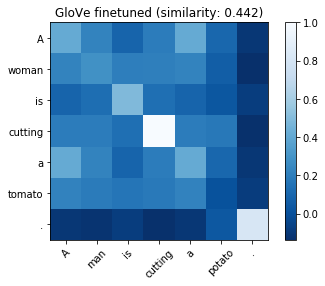

In [12]:
emb_l = np.dot(input_l, embedding_W)
emb_r = np.dot(input_r, embedding_W)

S_emb = np.dot(emb_l, emb_r.T)
S_emb /= np.max(S_emb)

plot_alignment_matrix(S_emb, sent_l, sent_r, "GloVe finetuned")

Some noteworthy things about the output from the original sentence pair.

* tomato and potato have high correspondence in GloVe space.
* man and woman have slightly lower, but still high correspondence in GloVe space.
* period seems to be very different from the other words.
* "a", "is" have lower correspondence with themselves in GloVe space, most likely since they are stopwords and can occur with many other kinds of words.

    
## Visualize Encodings

### Visualize Encoding Alignments

This is the alignment of output of the sentence encoder. The sentence matrices correspond to the sentences whose embeddings have been trained through a bidirectional LSTM.

/Users/palsujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.4-py2.7.egg/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


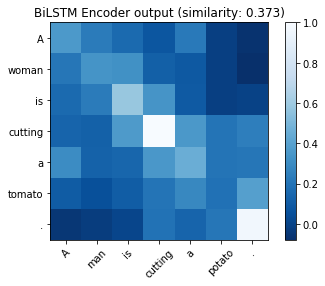

In [13]:
intseq_l = convert_to_sequence(sent_l, word2id, MAX_WORDS)
intseq_r = convert_to_sequence(sent_r, word2id, MAX_WORDS)
inputs = np.array([intseq_l, intseq_r])
enc_l, enc_r = sent_encoder.predict(inputs)

S_enc = np.dot(enc_l, enc_r.T)
S_enc /= np.max(S_enc)

plot_alignment_matrix(S_enc, sent_l, sent_r, "BiLSTM Encoder output")

## Visualize Attention (Parikh)

In this section, we consider the matrices output from the encoder for each of the LHS and RHS sentences as inputs to the encoder. Alignment is computed using the encoder outputs, then the alignment weights applied to the same matrices, as shown [here](https://github.com/sujitpal/eeap-examples/blob/master/docs/eeap-3d-block.png).

### Extract Attention Weights

In [14]:
att_tensors = model.layers[3].weights
att_tensor_names = ["W1", "b1", "W2", "b2", 
                    "U1", "U2", "V1", "V2"]
att_weights = {}
for idx, att_tensor in enumerate(att_tensors):
    att_weights[att_tensor_names[idx]] = att_tensor.eval(session)
    print(att_tensor_names[idx], att_weights[att_tensor_names[idx]].shape)

W1 (200, 200)
b1 (35, 200)
W2 (200, 200)
b2 (35, 200)
U1 (200, 200)
U2 (200, 200)
V1 (200, 200)
V2 (200, 200)


### Attention layer inputs

In [15]:
enc_l.shape, enc_r.shape

((35, 200), (35, 200))

### Compute alignment

In [16]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

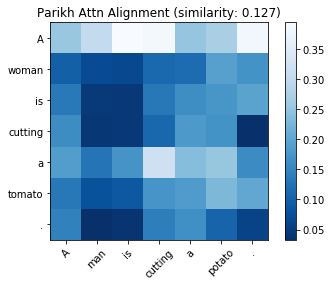

In [17]:
et_l = np.tanh(np.dot(enc_l, att_weights["W1"]) + att_weights["b1"])
et_r = np.tanh(np.dot(enc_r, att_weights["W2"]) + att_weights["b2"])

S_align = softmax(np.dot(et_l, et_r.T))
S_align /= np.max(S_align)

plot_alignment_matrix(S_align, sent_l, sent_r, "Parikh Attn Alignment")

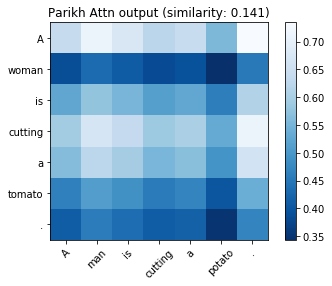

In [18]:
align_l = np.dot(S_align, enc_r)
align_r = np.dot(S_align.T, enc_l)

attout_l = np.tanh(np.dot(enc_l, att_weights["U1"]) +
                   np.dot(align_l, att_weights["V1"]))
attout_r = np.tanh(np.dot(enc_r, att_weights["U2"]) +
                   np.dot(align_r, att_weights["V2"]))

S_att = np.dot(attout_l, attout_r.T)
S_att /= np.max(S_att)

plot_alignment_matrix(S_att, sent_l, sent_r, "Parikh Attn output")

## Visualize Attention (Parikh) - take 2

Here, instead of using the output of the encoder for alignment, we use the output of the embed step, since visually the embedding alignments appear to be more in line with human expectations.

### Compute Attention (using Embedding alignment)

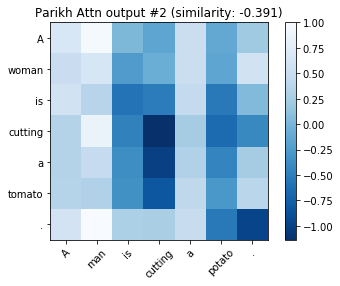

In [19]:
align2_l = np.dot(S_emb, enc_r)
align2_r = np.dot(S_emb.T, enc_l)

attout2_l = np.tanh(np.dot(enc_l, att_weights["U1"]) +
                   np.dot(align2_l, att_weights["V1"]))
attout2_r = np.tanh(np.dot(enc_r, att_weights["U2"]) +
                   np.dot(align2_r, att_weights["V2"]))

S_att2 = np.dot(attout2_l, attout2_r.T)
S_att2 /= np.max(S_att2)

plot_alignment_matrix(S_att2, sent_l, sent_r, "Parikh Attn output #2")